In [1]:
!nvidia-smi

Thu Oct 31 08:44:31 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      On  |   00000000:00:03.0 Off |                    0 |
| N/A   51C    P8             17W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!conda info --envs

# conda environments:
#
base                     /opt/conda
b-lora                *  /opt/conda/envs/b-lora
jupyterlab               /opt/conda/envs/jupyterlab
langsam                  /opt/conda/envs/langsam
pytorch                  /opt/conda/envs/pytorch
tensorflow               /opt/conda/envs/tensorflow
yolo                     /opt/conda/envs/yolo
yolo_app                 /opt/conda/envs/yolo_app



In [3]:
import torch
from blora_utils import BLOCKS, filter_lora, scale_lora

from diffusers import (
    AutoencoderKL, 
    AutoPipelineForText2Image, 
    DDIMScheduler,
    TCDScheduler
)
from diffusers.utils import make_image_grid

import numpy as np

import torch


### Handling of the generation the content

In [4]:
def load_b_lora_to_unet(pipe, 
                        content_lora_model_id: str = '', 
                        style_lora_model_id: str = '', 
                        content_alpha: float = 1.,
                        style_alpha: float = 1.) -> None:
    try:
        # Get Content B-LoRA SD
        if content_lora_model_id:
            content_B_LoRA_sd, _ = pipe.lora_state_dict(content_lora_model_id)
            content_B_LoRA = filter_lora(content_B_LoRA_sd, BLOCKS['content'])
            content_B_LoRA = scale_lora(content_B_LoRA, content_alpha)
        else:
            content_B_LoRA = {}

        # Get Style B-LoRA SD
        if style_lora_model_id:
            style_B_LoRA_sd, _ = pipe.lora_state_dict(style_lora_model_id)
            style_B_LoRA = filter_lora(style_B_LoRA_sd, BLOCKS['style'])
            style_B_LoRA = scale_lora(style_B_LoRA, style_alpha)
        else:
            style_B_LoRA = {}

        # Merge B-LoRAs SD
        res_lora = {**content_B_LoRA, **style_B_LoRA}

        # Load
        pipe.load_lora_into_unet(res_lora, None, pipe.unet)
    except Exception as e:
        raise type(e)(f'failed to load_b_lora_to_unet, due to: {e}')

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print("device:", device)

model_id_or_path = "SG161222/RealVisXL_V5.0_Lightning" #"SG161222/RealVisXL_V5.0_Lightning" #stabilityai/stable-diffusion-xl-base-1.0 #
vae_id_or_path = "madebyollin/sdxl-vae-fp16-fix"

vae = AutoencoderKL.from_pretrained(vae_id_or_path, torch_dtype=torch.float16)

pipe_tex2img = AutoPipelineForText2Image.from_pretrained(model_id_or_path,
                                                              vae=vae,
                                                              torch_dtype=torch.float16,
                                                            )              

# Setting up of others parameters
pipe_tex2img.enable_xformers_memory_efficient_attention()
pipe_tex2img = pipe_tex2img.to(device)

# Update of the scheduler
# pipe_tex2img.scheduler = TCDScheduler.from_config(pipe_tex2img.scheduler.config)
pipe_tex2img.scheduler = DDIMScheduler.from_config(pipe_tex2img.scheduler.config)

device: cuda


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
content_B_LoRA_path = ""
style_B_LoRA_path = "data/b-lora/wayfair-multi-captioned/pytorch_lora_weights.safetensors" #"data/b-lora/Dordogne/pytorch_lora_weights.safetensors" # "data/b-lora/Dordogne/checkpoint-500/pytorch_lora_weights.safetensors" #
content_alpha, style_alpha = 1, 1.1
lora_trigger_word = "[way1]"

In [12]:
load_b_lora_to_unet(pipe_tex2img, content_B_LoRA_path, style_B_LoRA_path, content_alpha, style_alpha)

seed: 858441
prompt: The image shows a modern living room in style [way1].

negative_prompt: worst quality, normal quality, low quality, low res, blurry, distortion, text, watermark, logo, banner, extra digits, cropped, jpeg artifacts, signature, username, error, sketch, duplicate, ugly, monochrome, horror, geometry, mutation, disgusting, bad anatomy, bad proportions, bad quality, deformed, disconnected limbs, out of frame, out of focus, dehydrated, disfigured, extra arms, extra limbs, extra hands, fused fingers, gross proportions, long neck, jpeg, malformed limbs, mutated, mutated hands, mutated limbs, missing arms, missing fingers, picture frame, poorly drawn hands, poorly drawn face, collage, pixel, pixelated, grainy, color aberration, amputee, autograph, bad illustration, beyond the borders, blank background, body out of frame, boring background, branding, cut off, dismembered, disproportioned, distorted, draft, duplicated features, extra fingers, extra legs, fault, flaw, grains, h

  0%|          | 0/30 [00:00<?, ?it/s]

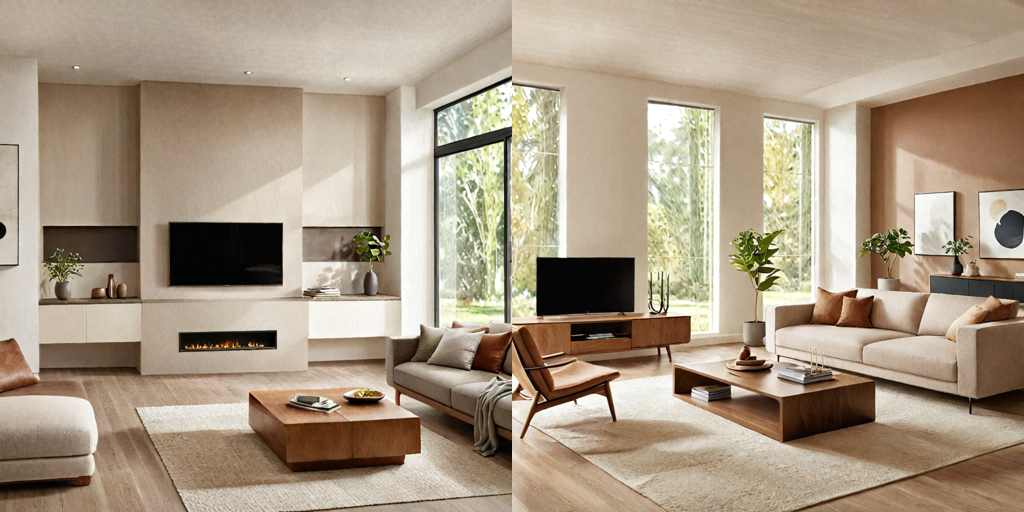

In [13]:
seed = torch.randint(0, 1000000, (1,)).item()
generator = torch.Generator(device=device).manual_seed(seed)
print(f"seed: {seed}")

# batch size
N = 2
steps = 30
guidance_scale=3.5

# prompt instanciation
# prompt = f'The image shows a chair in a living room in style {lora_trigger_word} with a very large rug on the floor, windows, a cupboard with books and a photo frame on top, a window with a curtain, and a wall in the background, plant in pot, painting on wall, stright-lines.'
# prompt = f"The image shows a modern nightstand in style {lora_trigger_word} with a lamp on top of it. The lamp has a gold-colored metal base and a round glass shade. The shade is filled with pink flowers in a glass vase. The nightstand is next to a white bed with a blue headboard. The wall behind the bed has a white geometric patterned wallpaper."
prompt = f"The image shows a modern living room in style {lora_trigger_word}."
print(f"prompt: {prompt}\n")

negative_prompt = "worst quality, normal quality, low quality, low res, blurry, distortion, text, watermark, logo, banner, extra digits, cropped, jpeg artifacts, signature, username, error, sketch, duplicate, ugly, monochrome, horror, geometry, mutation, disgusting, bad anatomy, bad proportions, bad quality, deformed, disconnected limbs, out of frame, out of focus, dehydrated, disfigured, extra arms, extra limbs, extra hands, fused fingers, gross proportions, long neck, jpeg, malformed limbs, mutated, mutated hands, mutated limbs, missing arms, missing fingers, picture frame, poorly drawn hands, poorly drawn face, collage, pixel, pixelated, grainy, color aberration, amputee, autograph, bad illustration, beyond the borders, blank background, body out of frame, boring background, branding, cut off, dismembered, disproportioned, distorted, draft, duplicated features, extra fingers, extra legs, fault, flaw, grains, hazy, identifying mark, improper scale, incorrect physiology, incorrect ratio, indistinct, kitsch, low resolution, macabre, malformed, mark, misshapen, missing hands, missing legs, mistake, morbid, mutilated, off-screen, outside the picture, poorly drawn feet, printed words, render, repellent, replicate, reproduce, revolting dimensions, script, shortened, sign, split image, squint, storyboard, tiling, trimmed, unfocused, unattractive, unnatural pose, unreal engine, unsightly, written language"
print(f"negative_prompt: {negative_prompt}\n")

# creation of the image(s)
images_output = pipe_tex2img(prompt=prompt, 
                                  negative_prompt=negative_prompt,
                                  num_inference_steps=steps,
                                  num_images_per_prompt=N,
                                  guidance_scale=guidance_scale,
                                  generator=generator).images

# save of the image
images_output[0].save(f'blora_result_with_negative_prompt.png', "PNG")

make_image_grid(images_output, rows=1, cols=N, resize=512)

  0%|          | 0/30 [00:00<?, ?it/s]

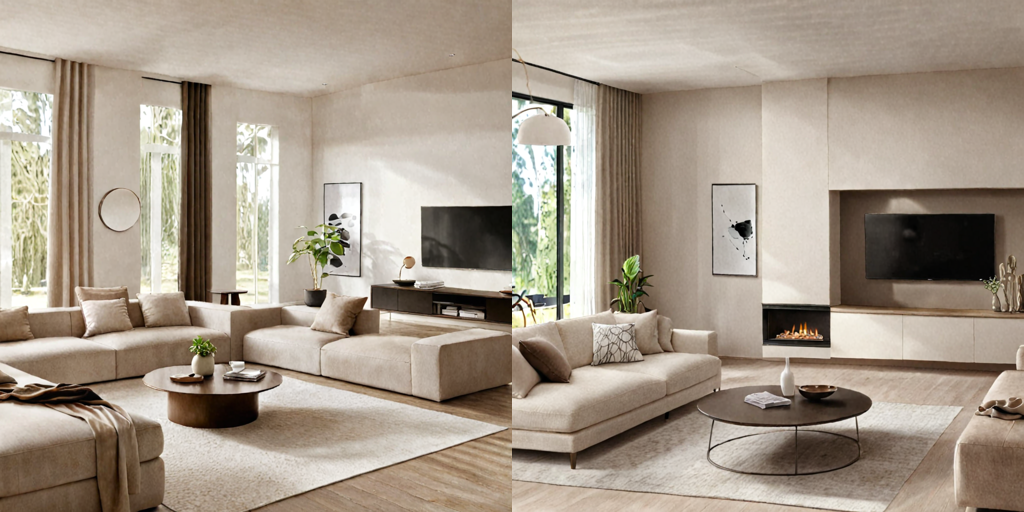

In [14]:
# creation of the image(s)
images_output = pipe_tex2img(prompt=prompt, 
                              negative_prompt=None,
                              num_inference_steps=steps,
                              num_images_per_prompt=N,
                              guidance_scale=guidance_scale,
                              generator=generator).images

images_output[0].save(f'blora_result_without_empty_negative_prompt.png', "PNG")

make_image_grid(images_output, rows=1, cols=N, resize=512)